# Import

In [85]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

import copy
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pytransform3d
import pytransform3d.camera as pc
import pytransform3d.rotations as pr
import pytransform3d.transformations as pt
from pytransform3d.urdf import UrdfTransformManager
from pytransform3d.plot_utils import make_3d_axis, plot_vector
from urdf_parser_py.urdf import URDF
from pytransform3d import rotations as pr

import math
import json
import itertools
from scipy.optimize import minimize, least_squares

import torch
from torch.nn.functional import mse_loss

import time
import cv2.aruco as aruco
from pytorch_kinematics.transforms.rotation_conversions import matrix_to_axis_angle

# Helper Functions

In [67]:
def load_json(filename: str):
    # Construct the absolute path by joining the current directory and relative path
    absolute_path = os.path.join(os.getcwd(), '..', filename)
    # Load the JSON data
    with open(absolute_path, 'r') as file:
        json_data = json.load(file)    
    return json_data

def xml_to_str(robot):
    # To XML string with filtering
    temp_str = robot.to_xml_string()
    words = temp_str.split()
    words[5] = '>'
    urdf_str = ' '.join(words)
    return urdf_str
        
def active_matrix_from_angle(basis, angle):
    c = torch.cos(angle)  # Shape: Nx1
    s = torch.sin(angle)  # Shape: Nx1
    
    if basis == 0:
        R = torch.zeros((angle.size(0), 3, 3), dtype=angle.dtype, device=angle.device)
        R[:, 0, 0] = 1.0
        R[:, 1, 1] = c.squeeze()  # Shape: N
        R[:, 1, 2] = -s.squeeze()  # Shape: N
        R[:, 2, 1] = s.squeeze()    # Shape: N
        R[:, 2, 2] = c.squeeze()    # Shape: N
    elif basis == 1:
        R = torch.zeros((angle.size(0), 3, 3), dtype=angle.dtype, device=angle.device)
        R[:, 0, 0] = c.squeeze()    # Shape: N
        R[:, 0, 2] = s.squeeze()    # Shape: N
        R[:, 1, 1] = 1.0
        R[:, 2, 0] = -s.squeeze()    # Shape: N
        R[:, 2, 2] = c.squeeze()    # Shape: N
    elif basis == 2:
        R = torch.zeros((angle.size(0), 3, 3), dtype=angle.dtype, device=angle.device)
        R[:, 0, 0] = c.squeeze()    # Shape: N
        R[:, 0, 1] = -s.squeeze()   # Shape: N
        R[:, 1, 0] = s.squeeze()    # Shape: N
        R[:, 1, 1] = c.squeeze()    # Shape: N
        R[:, 2, 2] = 1.0
    else:
        raise ValueError("Basis must be in [0, 1, 2]")
    
    return R

def active_matrix_from_extrinsic_euler_xyz(alpha, beta, gamma):
    # Calculate the rotation matrices
    R_alpha = active_matrix_from_angle(0, alpha)  # Rotation around x-axis
    R_beta = active_matrix_from_angle(1, beta)    # Rotation around y-axis
    R_gamma = active_matrix_from_angle(2, gamma)   # Rotation around z-axis

    # Combine the matrices using the @ operator
    R = R_gamma @ (R_beta @ R_alpha)
    return R

def get_homogeneous_matrix(roll,pitch,yaw,x,y,z):
    rot_mat = active_matrix_from_extrinsic_euler_xyz(roll,pitch,yaw)
    H = torch.zeros((rot_mat.size(0), 4, 4), dtype=dtype, device=device)
    H[:, :3, :3] = rot_mat
    H[:, 0, 3] = x.squeeze()
    H[:, 1, 3] = y.squeeze()
    H[:, 2, 3] = z.squeeze()
    H[:, 3, 3] = 1.0
    return H

# Initialization

In [3]:
# Explicitly telling to use GPU
torch.set_default_device('cuda')
torch.set_default_dtype(d=torch.float64)

In [4]:
# PyTorch Configs

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float64

In [5]:
# Load Configs
cam_mtxs = load_json('camera_mtx.json')
gaze_ctrs = load_json('calib_params.json')
data_fn = '241003_075m_grace_dataset.csv'
data_dir = 'thesis'
files_path = os.path.join(os.getcwd(),"..",'data', data_dir, data_fn)
df = pd.read_csv(files_path)

# Home Position

In [6]:
# Filtered df
home_df = df[(df['cmd_theta_lower_neck_tilt']==0) 
             & (df['cmd_theta_lower_neck_pan']==0) 
             & (df['cmd_theta_upper_neck_tilt']==0)
             & (df['cmd_theta_left_eye_pan']==0)
             & (df['cmd_theta_right_eye_pan']==0)
             & (df['cmd_theta_eyes_tilt']==0)]
home_df = home_df.reset_index(drop=True)

# Rvec and Tvec
home_l_rvec = np.array([home_df['l_rvec_0'],home_df['l_rvec_1'],home_df['l_rvec_2']])
home_l_tvec = np.array([home_df['l_tvec_0'],home_df['l_tvec_1'],home_df['l_tvec_2']])
temp_rmat,_ = cv2.Rodrigues(home_l_rvec)
T_home = np.eye(4)
T_home[:3,:3] = temp_rmat.squeeze()
T_home[:3,3] = home_l_tvec.flatten() 
T_home_inv = np.linalg.inv(T_home)

print('home_l_rvec:',home_l_rvec.flatten())
print('home_l_tvec:',home_l_tvec.flatten())
print('T_home', T_home)
print('T_home', T_home_inv)

home_l_rvec: [-0.03831161  0.09760042  0.02837561]
home_l_tvec: [-0.00941834  0.21086471 -0.02412313]
T_home [[ 0.99483957 -0.03018762  0.09686558 -0.00941834]
 [ 0.02645206  0.99886464  0.03961969  0.21086471]
 [-0.09795162 -0.03685294  0.99450859 -0.02412313]
 [ 0.          0.          0.          1.        ]]
T_home [[ 0.99483957  0.02645206 -0.09795162  0.00142904]
 [-0.03018762  0.99886464 -0.03685294 -0.21179863]
 [ 0.09686558  0.03961969  0.99450859  0.01654858]
 [ 0.          0.          0.          1.        ]]


## Relative to Left Home Position

In [7]:
T_clprime_list = []
l_0lprime_pose_list = []
l_0lprime_roll_list = []
l_0lprime_pitch_list = []
l_0lprime_yaw_list = []
l_0lprime_x_list = []
l_0lprime_y_list = []
l_0lprime_z_list = []
for i in range(len(df)):
    # Getting Homogeneous Matrix
    l_rvec = np.array([df['l_rvec_0'][i],df['l_rvec_1'][i],df['l_rvec_2'][i]])
    l_tvec = np.array([df['l_tvec_0'][i],df['l_tvec_1'][i],df['l_tvec_2'][i]])
    l_rmat,_ = cv2.Rodrigues(l_rvec)
    T_clprime = np.eye(4)
    T_clprime[:3,:3] = l_rmat.squeeze()
    T_clprime[:3,3] = l_tvec.flatten()
    T_clprime_list.append(T_clprime)

    # Getting Relative Rotation
    T_0lprime = T_home_inv @ T_clprime
    roll,pitch,yaw = pr.extrinsic_euler_xyz_from_active_matrix(T_0lprime[:3,:3])
    x,y,z = T_0lprime[:3,3].flatten()
    l_0lprime_x_list.append(x)
    l_0lprime_y_list.append(y)
    l_0lprime_z_list.append(z)
    l_0lprime_roll_list.append(roll)
    l_0lprime_pitch_list.append(pitch)
    l_0lprime_yaw_list.append(yaw)
    l_0lprime_pose_list.append(T_0lprime)

# Saving to Dataframe
df['T_clprime'] = T_clprime_list
df['l_roll'] = l_0lprime_roll_list
df['l_pitch'] = l_0lprime_pitch_list
df['l_yaw'] = l_0lprime_yaw_list
df['l_x'] = l_0lprime_x_list
df['l_y'] = l_0lprime_y_list
df['l_z'] = l_0lprime_z_list
df['T_0lprime'] = l_0lprime_pose_list

## Plotting

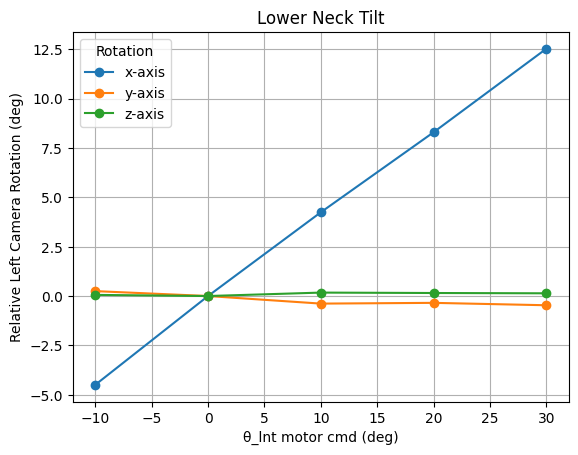

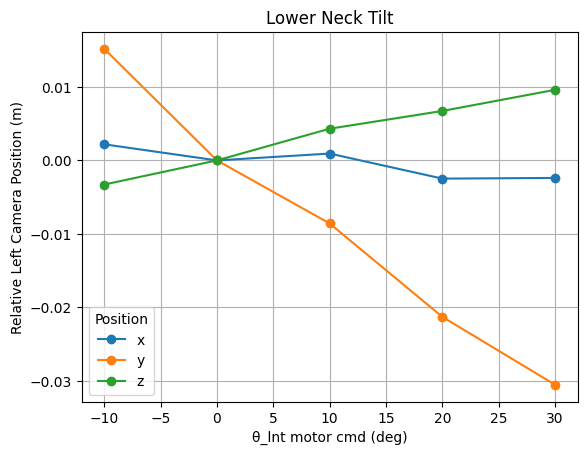

In [8]:
# Plot Lower Neck Tilt (Right Hand Rule)
filtered_df = df[((df['cmd_theta_lower_neck_pan']==0) 
             & (df['cmd_theta_upper_neck_tilt']==0)
             & (df['cmd_theta_left_eye_pan']==0)
             & (df['cmd_theta_right_eye_pan']==0)
             & (df['cmd_theta_eyes_tilt']==0))]

plt.figure()
plt.plot(filtered_df['cmd_theta_lower_neck_tilt'].values, np.degrees(filtered_df['l_roll'].values), marker='o')
plt.plot(filtered_df['cmd_theta_lower_neck_tilt'].values, np.degrees(filtered_df['l_pitch'].values), marker='o')
plt.plot(filtered_df['cmd_theta_lower_neck_tilt'].values, np.degrees(filtered_df['l_yaw'].values), marker='o')
plt.legend(['x-axis','y-axis','z-axis'],title='Rotation')
plt.title('Lower Neck Tilt')
plt.xlabel('θ_lnt motor cmd (deg)')
plt.ylabel('Relative Left Camera Rotation (deg)')
plt.grid()

plt.figure()
plt.plot(filtered_df['cmd_theta_lower_neck_tilt'].values, filtered_df['l_x'].values, marker='o')
plt.plot(filtered_df['cmd_theta_lower_neck_tilt'].values, filtered_df['l_y'].values, marker='o')
plt.plot(filtered_df['cmd_theta_lower_neck_tilt'].values, filtered_df['l_z'].values, marker='o')
plt.legend(['x','y','z'],title='Position')
plt.title('Lower Neck Tilt')
plt.xlabel('θ_lnt motor cmd (deg)')
plt.ylabel('Relative Left Camera Position (m)')
plt.grid()

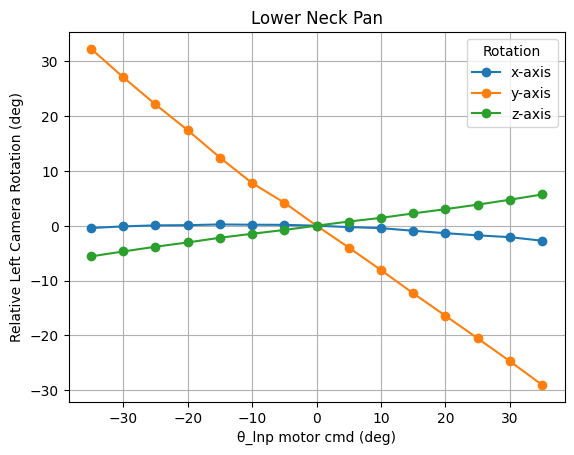

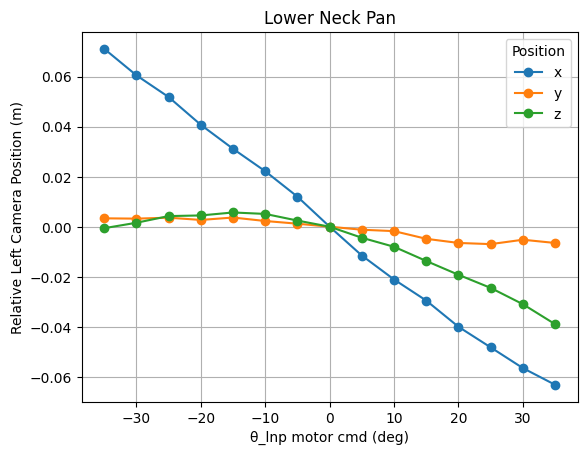

In [9]:
# Plot Lower Neck Pan (Right Hand Rule)
filtered_df = df[((df['cmd_theta_lower_neck_tilt']==0) 
             & (df['cmd_theta_upper_neck_tilt']==0)
             & (df['cmd_theta_left_eye_pan']==0)
             & (df['cmd_theta_right_eye_pan']==0)
             & (df['cmd_theta_eyes_tilt']==0))]

plt.figure()
plt.plot(filtered_df['cmd_theta_lower_neck_pan'].values, np.degrees(filtered_df['l_roll'].values), marker='o')
plt.plot(filtered_df['cmd_theta_lower_neck_pan'].values, np.degrees(filtered_df['l_pitch'].values), marker='o')
plt.plot(filtered_df['cmd_theta_lower_neck_pan'].values, np.degrees(filtered_df['l_yaw'].values), marker='o')
plt.legend(['x-axis','y-axis','z-axis'],title='Rotation')
plt.title('Lower Neck Pan')
plt.xlabel('θ_lnp motor cmd (deg)')
plt.ylabel('Relative Left Camera Rotation (deg)')
plt.grid()

plt.figure()
plt.plot(filtered_df['cmd_theta_lower_neck_pan'].values, filtered_df['l_x'].values, marker='o')
plt.plot(filtered_df['cmd_theta_lower_neck_pan'].values, filtered_df['l_y'].values, marker='o')
plt.plot(filtered_df['cmd_theta_lower_neck_pan'].values, filtered_df['l_z'].values, marker='o')
plt.legend(['x','y','z'],title='Position')
plt.title('Lower Neck Pan')
plt.xlabel('θ_lnp motor cmd (deg)')
plt.ylabel('Relative Left Camera Position (m)')
plt.grid()

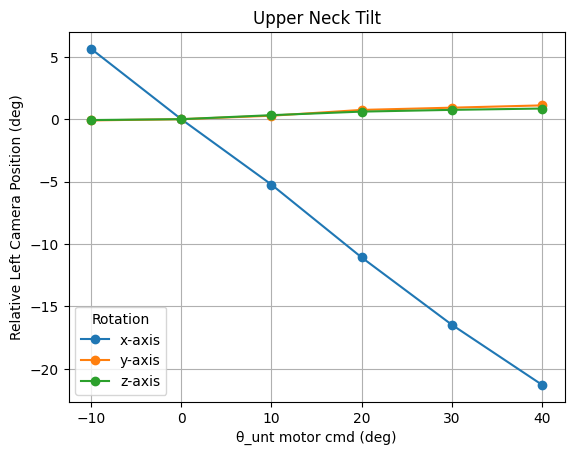

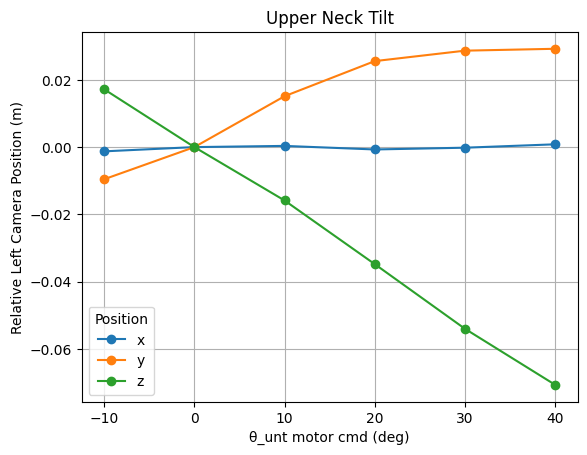

In [10]:
# Plot Upper Neck Tilt (Right Hand Rule)
filtered_df = df[((df['cmd_theta_lower_neck_tilt']==0) 
             & (df['cmd_theta_lower_neck_pan']==0)
             & (df['cmd_theta_left_eye_pan']==0)
             & (df['cmd_theta_right_eye_pan']==0)
             & (df['cmd_theta_eyes_tilt']==0))]

plt.figure()
plt.plot(filtered_df['cmd_theta_upper_neck_tilt'].values, np.degrees(filtered_df['l_roll'].values), marker='o')
plt.plot(filtered_df['cmd_theta_upper_neck_tilt'].values, np.degrees(filtered_df['l_pitch'].values), marker='o')
plt.plot(filtered_df['cmd_theta_upper_neck_tilt'].values, np.degrees(filtered_df['l_yaw'].values), marker='o')
plt.legend(['x-axis','y-axis','z-axis'],title='Rotation')
plt.title('Upper Neck Tilt')
plt.xlabel('θ_unt motor cmd (deg)')
plt.ylabel('Relative Left Camera Position (deg)')
plt.grid()

plt.figure()
plt.plot(filtered_df['cmd_theta_upper_neck_tilt'].values, filtered_df['l_x'].values, marker='o')
plt.plot(filtered_df['cmd_theta_upper_neck_tilt'].values, filtered_df['l_y'].values, marker='o')
plt.plot(filtered_df['cmd_theta_upper_neck_tilt'].values, filtered_df['l_z'].values, marker='o')
plt.legend(['x','y','z'],title='Position')
plt.title('Upper Neck Tilt')
plt.xlabel('θ_unt motor cmd (deg)')
plt.ylabel('Relative Left Camera Position (m)')
plt.grid()

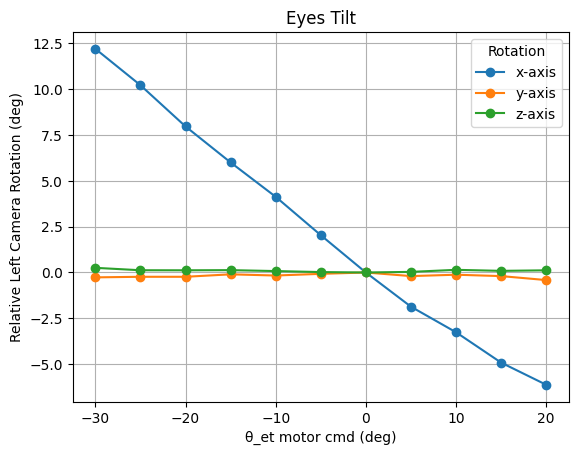

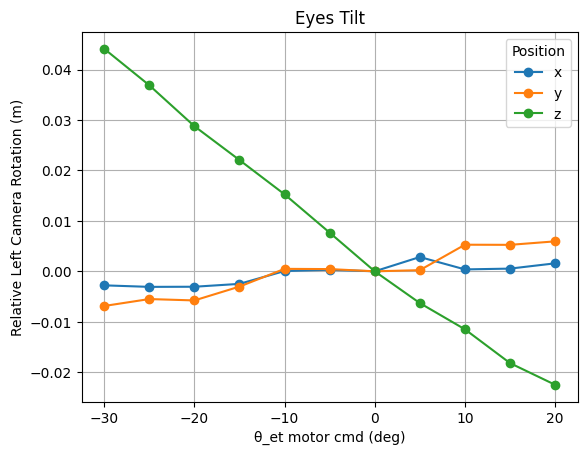

In [11]:
# Plot Eyes Tilt (Right Hand Rule)
filtered_df = df[((df['cmd_theta_lower_neck_tilt']==0) 
             & (df['cmd_theta_lower_neck_pan']==0)
             & (df['cmd_theta_upper_neck_tilt']==0)    
             & (df['cmd_theta_left_eye_pan']==0)
             & (df['cmd_theta_right_eye_pan']==0))]

plt.figure()
plt.plot(filtered_df['cmd_theta_eyes_tilt'].values, np.degrees(filtered_df['l_roll'].values), marker='o')
plt.plot(filtered_df['cmd_theta_eyes_tilt'].values, np.degrees(filtered_df['l_pitch'].values), marker='o')
plt.plot(filtered_df['cmd_theta_eyes_tilt'].values, np.degrees(filtered_df['l_yaw'].values), marker='o')
plt.legend(['x-axis','y-axis','z-axis'],title='Rotation')
plt.title('Eyes Tilt')
plt.xlabel('θ_et motor cmd (deg)')
plt.ylabel('Relative Left Camera Rotation (deg)')
plt.grid()

plt.figure()
plt.plot(filtered_df['cmd_theta_eyes_tilt'].values, filtered_df['l_x'].values, marker='o')
plt.plot(filtered_df['cmd_theta_eyes_tilt'].values, filtered_df['l_y'].values, marker='o')
plt.plot(filtered_df['cmd_theta_eyes_tilt'].values, filtered_df['l_z'].values, marker='o')
plt.legend(['x','y','z'],title='Position')
plt.title('Eyes Tilt')
plt.xlabel('θ_et motor cmd (deg)')
plt.ylabel('Relative Left Camera Rotation (m)')
plt.grid()

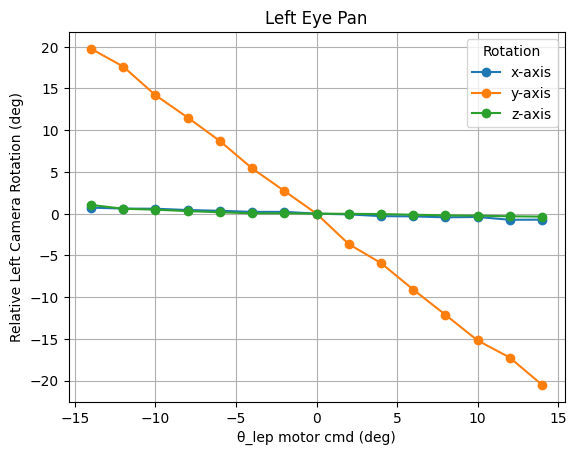

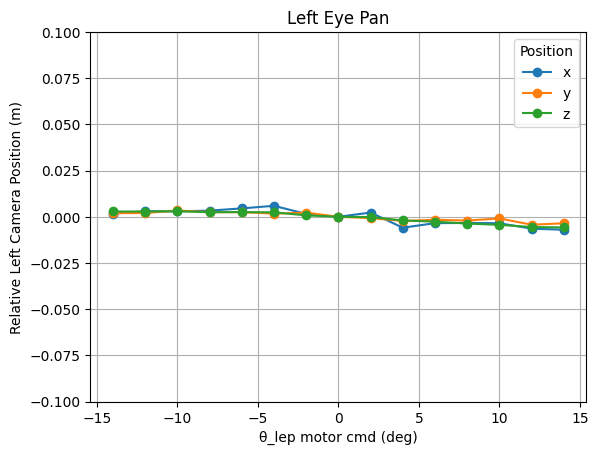

In [12]:
# Plot Left Eye Pan (Right Hand Rule)
filtered_df = df[((df['cmd_theta_lower_neck_tilt']==0) 
             & (df['cmd_theta_lower_neck_pan']==0)
             & (df['cmd_theta_upper_neck_tilt']==0)
             & (df['cmd_theta_eyes_tilt']==0))]

plt.figure()
plt.plot(filtered_df['cmd_theta_left_eye_pan'].values, np.degrees(filtered_df['l_roll'].values), marker='o')
plt.plot(filtered_df['cmd_theta_left_eye_pan'].values, np.degrees(filtered_df['l_pitch'].values), marker='o')
plt.plot(filtered_df['cmd_theta_left_eye_pan'].values, np.degrees(filtered_df['l_yaw'].values), marker='o')
plt.legend(['x-axis','y-axis','z-axis'],title='Rotation')
plt.title('Left Eye Pan')
plt.xlabel('θ_lep motor cmd (deg)')
plt.ylabel('Relative Left Camera Rotation (deg)')
plt.grid()
plt.show()

plt.figure()
plt.plot(filtered_df['cmd_theta_left_eye_pan'].values, filtered_df['l_x'].values, marker='o')
plt.plot(filtered_df['cmd_theta_left_eye_pan'].values, filtered_df['l_y'].values, marker='o')
plt.plot(filtered_df['cmd_theta_left_eye_pan'].values, filtered_df['l_z'].values, marker='o')
plt.legend(['x','y','z'],title='Position')
plt.title('Left Eye Pan')
plt.xlabel('θ_lep motor cmd (deg)')
plt.ylabel('Relative Left Camera Position (m)')
plt.ylim([-0.1,0.1])
plt.grid()

# Learning

In [13]:
# Removed home position
temp_df = df[~((df['cmd_theta_lower_neck_tilt']==0) 
             & (df['cmd_theta_lower_neck_pan']==0) 
             & (df['cmd_theta_upper_neck_tilt']==0)
             & (df['cmd_theta_left_eye_pan']==0)
             & (df['cmd_theta_right_eye_pan']==0)
             & (df['cmd_theta_eyes_tilt']==0))]

# Convert DF Degrees Column to Radians
data_df = temp_df.copy()
data_df['cmd_theta_lower_neck_pan'] = np.radians(temp_df['cmd_theta_lower_neck_pan'].values)
data_df['cmd_theta_lower_neck_tilt'] = np.radians(temp_df['cmd_theta_lower_neck_tilt'].values)
data_df['cmd_theta_upper_neck_tilt'] = np.radians(temp_df['cmd_theta_upper_neck_tilt'].values)
data_df['cmd_theta_left_eye_pan'] = np.radians(temp_df['cmd_theta_left_eye_pan'].values)
data_df['cmd_theta_right_eye_pan'] = np.radians(temp_df['cmd_theta_right_eye_pan'].values)
data_df['cmd_theta_eyes_tilt'] = np.radians(temp_df['cmd_theta_eyes_tilt'].values)
data_df

,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,...,r_tvec_1,r_tvec_2,T_clprime,l_roll,l_pitch,l_yaw,l_x,l_y,l_z,T_0lprime
0,-0.873669,-0.334702,0.738088,-1.166921,-0.352033,0.738508,-0.610865,-0.174533,-0.174533,-0.244346,...,0.213112,-0.041406,"[[0.5355028682660912, -0.028916368354528342, 0...",-0.155323,0.904837,-0.133001,0.059394,0.003733,-0.034926,"[[0.6123574763160962, 0.010443224023757186, 0...."
1,-0.821681,-0.331576,0.738000,-0.997318,-0.340332,0.738221,-0.610865,-0.174533,-0.174533,-0.209440,...,0.214858,-0.040722,"[[0.5618559701183278, -0.026234443158130644, 0...",-0.148631,0.873507,-0.127437,0.059835,0.005283,-0.032203,"[[0.6369349236642802, 0.013092430189091862, 0...."
2,-0.731501,-0.324165,0.738176,-0.868484,-0.332085,0.738360,-0.610865,-0.174533,-0.174533,-0.174533,...,0.215170,-0.040686,"[[0.6124823516682752, -0.018149043232688206, 0...",-0.138241,0.810950,-0.121817,0.063781,0.004925,-0.029259,"[[0.6837057210695074, 0.021199228839610666, 0...."
3,-0.672994,-0.320809,0.737795,-0.776648,-0.327031,0.737932,-0.610865,-0.174533,-0.174533,-0.139626,...,0.213963,-0.040592,"[[0.6449913497051157, -0.013033807255748799, 0...",-0.135140,0.768923,-0.120912,0.063719,0.003881,-0.027184,"[[0.7134127407434459, 0.02651707414720723, 0.7..."
4,-0.613507,-0.317492,0.737656,-0.690487,-0.321762,0.737752,-0.610865,-0.174533,-0.174533,-0.104720,...,0.213913,-0.039848,"[[0.680806455995241, -0.006690230040100394, 0....",-0.129975,0.720883,-0.119165,0.065874,0.004151,-0.022807,"[[0.7458955698500657, 0.03293885821373599, 0.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71547,0.665592,-0.272499,0.699880,0.621062,-0.265477,0.702477,0.610865,0.523599,0.698132,0.104720,...,0.193151,-0.128256,"[[0.8201366995566274, -0.24394387010543128, -0...",-0.047312,-0.653030,0.242451,-0.066625,-0.009902,-0.056421,"[[0.7710166992591192, -0.21191866898306536, -0..."
71548,0.730287,-0.287109,0.696013,0.683528,-0.280426,0.698749,0.610865,0.523599,0.698132,0.139626,...,0.193453,-0.135110,"[[0.7901479635005728, -0.24141835946161266, -0...",-0.064476,-0.706205,0.251923,-0.062267,-0.008394,-0.060516,"[[0.7368142771438941, -0.2082559538507491, -0...."
71549,0.802889,-0.302720,0.691989,0.750690,-0.295852,0.695038,0.610865,0.523599,0.698132,0.174533,...,0.192858,-0.141939,"[[0.7576384476059983, -0.23921144965672214, -0...",-0.082975,-0.759149,0.263978,-0.058535,-0.007436,-0.064526,"[[0.7002931269161005, -0.20495428949665997, -0..."
71550,0.859063,-0.315495,0.688613,0.810327,-0.309450,0.691467,0.610865,0.523599,0.698132,0.209440,...,0.193898,-0.146631,"[[0.733025572105265, -0.23567752375274492, -0....",-0.099578,-0.796888,0.273677,-0.054757,-0.007435,-0.068644,"[[0.6729239329302168, -0.20048127972598864, -0..."


In [22]:
# Decision Variables Initial Value

var_dict= {
    # Lower Neck Tilt
    'lnt_roll_b0': 0.1,
    'lnt_roll_b1': 0.1,
    'lnt_roll_b2': 0,
    'lnt_roll_b3': 0,
    'lnt_pitch_b0': 0.1,
    'lnt_pitch_b1': 0.1,
    'lnt_pitch_b2': 0,
    'lnt_pitch_b3': 0,
    'lnt_yaw_b0': 0.1,
    'lnt_yaw_b1': 0.1,
    'lnt_yaw_b2': 0,
    'lnt_yaw_b3': 0,
    'lnt_x_b0': 0.1,
    'lnt_x_b1': 0.1,
    'lnt_x_b2': 0,
    'lnt_x_b3': 0,
    'lnt_x_b0': 0.1,
    'lnt_x_b1': 0.1,
    'lnt_x_b2': 0,
    'lnt_x_b3': 0,
    'lnt_y_b0': 0.1,
    'lnt_y_b1': 0.1,
    'lnt_y_b2': 0,
    'lnt_y_b3': 0,
    'lnt_z_b0': 0.1,
    'lnt_z_b1': 0.1,
    'lnt_z_b2': 0,
    'lnt_z_b3': 0,

    # Lower Neck Pan
    'lnp_roll_b0': 0.1,
    'lnp_roll_b1': 0.1,
    'lnp_roll_b2': 0,
    'lnp_roll_b3': 0,
    'lnp_pitch_b0': 0.1,
    'lnp_pitch_b1': 0.1,
    'lnp_pitch_b2': 0,
    'lnp_pitch_b3': 0,
    'lnp_yaw_b0': 0.1,
    'lnp_yaw_b1': 0.1,
    'lnp_yaw_b2': 0,
    'lnp_yaw_b3': 0,
    'lnp_x_b0': 0.1,
    'lnp_x_b1': 0.1,
    'lnp_x_b2': 0,
    'lnp_x_b3': 0,
    'lnp_y_b0': 0.1,
    'lnp_y_b1': 0.1,
    'lnp_y_b2': 0,
    'lnp_y_b3': 0,
    'lnp_z_b0': 0.1,
    'lnp_z_b1': 0.1,
    'lnp_z_b2': 0,
    'lnp_z_b3': 0,

    # Upper Neck Tilt
    'unt_roll_b0': 0.1,
    'unt_roll_b1': 0.1,
    'unt_roll_b2': 0,
    'unt_roll_b3': 0,
    'unt_pitch_b0': 0.1,
    'unt_pitch_b1': 0.1,
    'unt_pitch_b2': 0,
    'unt_pitch_b3': 0,
    'unt_yaw_b0': 0.1,
    'unt_yaw_b1': 0.1,
    'unt_yaw_b2': 0,
    'unt_yaw_b3': 0,
    'unt_x_b0': 0.1,
    'unt_x_b1': 0.1,
    'unt_x_b2': 0,
    'unt_x_b3': 0,
    'unt_y_b0': 0.1,
    'unt_y_b1': 0.1,
    'unt_y_b2': 0,
    'unt_y_b3': 0,
    'unt_z_b0': 0.1,
    'unt_z_b1': 0.1,
    'unt_z_b2': 0,
    'unt_z_b3': 0,

    # Eyes Tilt
    'et_roll_b0': 0.1,
    'et_roll_b1': 0.1,
    'et_roll_b2': 0,
    'et_roll_b3': 0,
    'et_pitch_b0': 0.1,
    'et_pitch_b1': 0.1,
    'et_pitch_b2': 0,
    'et_pitch_b3': 0,
    'et_yaw_b0': 0.1,
    'et_yaw_b1': 0.1,
    'et_yaw_b2': 0,
    'et_yaw_b3': 0,
    'et_x_b0': 0.1,
    'et_x_b1': 0.1,
    'et_x_b2': 0,
    'et_x_b3': 0,
    'et_y_b0': 0.1,
    'et_y_b1': 0.1,
    'et_y_b2': 0,
    'et_y_b3': 0,
    'et_z_b0': 0.1,
    'et_z_b1': 0.1,
    'et_z_b2': 0,
    'et_z_b3': 0,


    # Left Eye Pan
    'lep_roll_b0': 0.1,
    'lep_roll_b1': 0.1,
    'lep_roll_b2': 0,
    'lep_roll_b3': 0,
    'lep_pitch_b0': 0.1,
    'lep_pitch_b1': 0.1,
    'lep_pitch_b2': 0,
    'lep_pitch_b3': 0,
    'lep_yaw_b0': 0.1,
    'lep_yaw_b1': 0.1,
    'lep_yaw_b2': 0,
    'lep_yaw_b3': 0,
    'lep_x_b0': 0.1,
    'lep_x_b1': 0.1,
    'lep_x_b2': 0,
    'lep_x_b3': 0,
    'lep_y_b0': 0.1,
    'lep_y_b1': 0.1,
    'lep_y_b2': 0,
    'lep_y_b3': 0,
    'lep_z_b0': 0.1,
    'lep_z_b1': 0.1,
    'lep_z_b2': 0,
    'lep_z_b3': 0,
}

# Decision Variables 
var_list = list(var_dict.values())

# Variable Names
var_names_list = list(var_dict.keys())

In [23]:
V = var_list

start = time.time()

### Joint-to-Motor Polynomial Models
x = torch.Tensor(data_df['cmd_theta_lower_neck_tilt']).reshape(-1,1).to(dtype=dtype, device=device)
lnt_roll = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[0]],[V[1]],[V[2]],[V[3]]]).to(dtype=dtype, device=device))
lnt_pitch = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[4]],[V[5]],[V[6]],[V[7]]]).to(dtype=dtype, device=device))
lnt_yaw = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[8]],[V[9]],[V[10]],[V[11]]]).to(dtype=dtype, device=device))
lnt_x = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[12]],[V[13]],[V[14]],[V[15]]]).to(dtype=dtype, device=device))
lnt_y = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[16]],[V[17]],[V[18]],[V[19]]]).to(dtype=dtype, device=device))
lnt_z = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[20]],[V[21]],[V[22]],[V[23]]]).to(dtype=dtype, device=device))

x = torch.Tensor(data_df['cmd_theta_lower_neck_pan']).reshape(-1,1).to(dtype=dtype, device=device)
lnp_roll = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[24]],[V[25]],[V[26]],[V[27]]]).to(dtype=dtype, device=device))
lnp_pitch = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[28]],[V[29]],[V[30]],[V[31]]]).to(dtype=dtype, device=device))
lnp_yaw = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[32]],[V[33]],[V[34]],[V[35]]]).to(dtype=dtype, device=device))
lnp_x = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[36]],[V[37]],[V[38]],[V[39]]]).to(dtype=dtype, device=device))
lnp_y = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[40]],[V[41]],[V[42]],[V[43]]]).to(dtype=dtype, device=device))
lnp_z = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[44]],[V[45]],[V[46]],[V[47]]]).to(dtype=dtype, device=device))

x = torch.Tensor(data_df['cmd_theta_upper_neck_tilt']).reshape(-1,1).to(dtype=dtype, device=device)
unt_roll = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[48]],[V[49]],[V[50]],[V[51]]]).to(dtype=dtype, device=device))
unt_pitch = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[52]],[V[53]],[V[54]],[V[55]]]).to(dtype=dtype, device=device))
unt_yaw = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[56]],[V[57]],[V[58]],[V[59]]]).to(dtype=dtype, device=device))
unt_x = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[60]],[V[61]],[V[62]],[V[63]]]).to(dtype=dtype, device=device))
unt_y = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[64]],[V[65]],[V[66]],[V[67]]]).to(dtype=dtype, device=device))
unt_z = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[68]],[V[69]],[V[70]],[V[71]]]).to(dtype=dtype, device=device))

x = torch.Tensor(data_df['cmd_theta_eyes_tilt']).reshape(-1,1).to(dtype=dtype, device=device)
et_roll = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[72]],[V[73]],[V[74]],[V[75]]]).to(dtype=dtype, device=device))
et_pitch = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[76]],[V[77]],[V[78]],[V[79]]]).to(dtype=dtype, device=device))
et_yaw = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[80]],[V[81]],[V[82]],[V[83]]]).to(dtype=dtype, device=device))
et_x = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[84]],[V[85]],[V[86]],[V[87]]]).to(dtype=dtype, device=device))
et_y = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[88]],[V[89]],[V[90]],[V[91]]]).to(dtype=dtype, device=device))
et_z = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[92]],[V[93]],[V[94]],[V[95]]]).to(dtype=dtype, device=device))

x = torch.Tensor(data_df['cmd_theta_left_eye_pan']).reshape(-1,1).to(dtype=dtype, device=device)
lep_roll = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[96]],[V[97]],[V[98]],[V[99]]]).to(dtype=dtype, device=device))
lep_pitch = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[100]],[V[101]],[V[102]],[V[103]]]).to(dtype=dtype, device=device))
lep_yaw = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[104]],[V[105]],[V[106]],[V[107]]]).to(dtype=dtype, device=device))
lep_x = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[108]],[V[109]],[V[110]],[V[111]]]).to(dtype=dtype, device=device))
lep_y = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[112]],[V[113]],[V[114]],[V[115]]]).to(dtype=dtype, device=device))
lep_z = (torch.cat((torch.ones(x.shape[0], 1), x, x.pow(2), x.pow(3)), dim=1) @ torch.Tensor([[V[116]],[V[117]],[V[118]],[V[119]]]).to(dtype=dtype, device=device))

In [80]:
# Home Homogeneous
T_temp = torch.Tensor(T_home).to(dtype=dtype, device=device)
T_0 = torch.stack([T_temp] * len(data_df))

# Homogeneous Matrices
T_lnt = get_homogeneous_matrix(lnt_roll,lnt_pitch,lnt_yaw,lnt_x,lnt_y,lnt_z)
T_lnp = get_homogeneous_matrix(lnp_roll,lnp_pitch,lnp_yaw,lnp_x,lnp_y,lnp_z)
T_unt = get_homogeneous_matrix(unt_roll,unt_pitch,unt_yaw,unt_x,unt_y,unt_z)
T_et = get_homogeneous_matrix(et_roll,et_pitch,et_yaw,et_x,et_y,et_z)
T_lep = get_homogeneous_matrix(lep_roll,lep_pitch,lep_yaw,lep_x,lep_y,lep_z)

In [83]:
# Final Matrix

T_final = T_0 @ T_lnt @ T_lnp @ T_unt @ T_et @ T_lep
T_final

tensor([[[ 0.7861, -0.2622,  0.5597,  0.4344],
         [ 0.4534,  0.8601, -0.2338,  0.6535],
         [-0.4201,  0.4375,  0.7950,  0.3257],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.7832, -0.2629,  0.5635,  0.4382],
         [ 0.4570,  0.8579, -0.2349,  0.6573],
         [-0.4217,  0.4415,  0.7920,  0.3286],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.7802, -0.2636,  0.5673,  0.4420],
         [ 0.4606,  0.8557, -0.2359,  0.6610],
         [-0.4232,  0.4453,  0.7890,  0.3314],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        ...,

        [[ 0.5595, -0.2500,  0.7902,  0.6939],
         [ 0.6727,  0.6940, -0.2568,  0.9093],
         [-0.4842,  0.6752,  0.5564,  0.5030],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.5557, -0.2492,  0.7932,  0.6978],
         [ 0.6758,  0.6911, -0.2563,  0.9131],
         [-0.4843,  0.6784,  0.5525,  0.5057],
         [ 0.0000,  0.0000,  0.0000,  1.0000]],

        [[ 0.5518, -0.2484,  0.7961,

In [87]:
# Rvec and Tvec

# True
l_rvec = np.concatenate([data_df['l_rvec_0'].values.reshape(-1,1),
                             data_df['l_rvec_1'].values.reshape(-1,1),
                             data_df['l_rvec_2'].values.reshape(-1,1)], axis=1)
l_tvec = np.concatenate([data_df['l_tvec_0'].values.reshape(-1,1),
                         data_df['l_tvec_1'].values.reshape(-1,1),
                         data_df['l_tvec_2'].values.reshape(-1,1)], axis=1)
l_rvec_t = torch.Tensor(l_rvec).to(dtype=dtype, device=device)
l_tvec_t = torch.Tensor(l_tvec).to(dtype=dtype, device=device)

# Predicted
pred_l_rvec = matrix_to_axis_angle(T_final[:,:3,:3])
pred_l_tvec = T_final[:,:3,3]

In [96]:
# Min-max normalization
min_val = min([pred_l_tvec.min(),l_tvec_t.min()])
max_val = max([pred_l_tvec.max(),l_tvec_t.max()])
print(min_val, max_val)

# Normalized Tvec
norm_l_tvec_t = (l_rvec_t - min_val) / (max_val - min_val)
norm_pred_l_tvec = (pred_l_tvec - min_val) / (max_val - min_val)

tensor(-0.1571, device='cuda:0') tensor(1.0143, device='cuda:0')


In [97]:
residuals = (mse_loss(pred_l_rvec, l_rvec_t) + mse_loss(norm_l_tvec_t, norm_pred_l_tvec)).cpu().item()
residuals

0.6617246666401236